# Agglomerative hierarchical clustering

A quick reminder on how agglomerative hierarchical clustering works: https://youtu.be/OcoE7JlbXvY

Goal:
* similar objects in same group
* dissimilar objects in different groups

Approach:
* form all possible singleton clusters (each containing a single object);
* greedily combine clusters with "maximum similarity" (or "minimum distance") together into a new cluster;
* continue until all objects are contained in a single cluster.

Different types of similarity:
* *single link* - similarity of two clusters considered for merging is determined by the two most similar members of the two clusters;
* *complete link* - similarity of two clusters is determined by the two least similar members of the two clusters;
* *group average* - similarity is determined by the average similarity between all members of the clusters considered.

 Considering the following uni-dimensional dataset:

In [1]:
import pandas as pd
d = pd.DataFrame({
    'X': [-2.2, -2.0, -0.3, 0.1, 0.2, 0.4, 1.6, 1.7, 1.9, 2.0],
})

Plotting it with `pyplot` shows roughly three "natural" clusters forming:

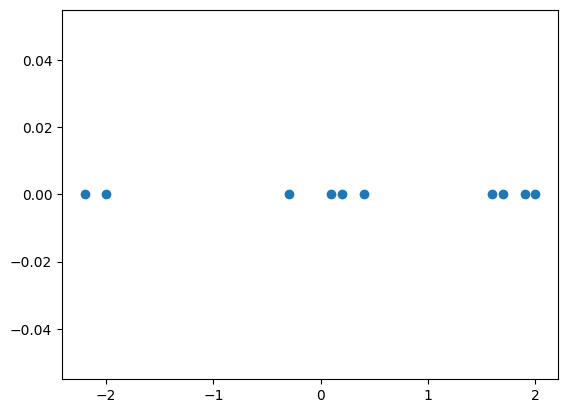

In [2]:
import numpy as np
import matplotlib.pyplot as plt

plt.scatter(d, np.zeros_like(d))
plt.show()

Using the `sklearn.cluster` module, we can use the agglomerative cluster algorithm with any of the three similarity (or "linkage") functions. For instance, if we want to use single linkage to find 3 clusters in the above dataset, we could run:

In [3]:
from sklearn.cluster import AgglomerativeClustering

ac = AgglomerativeClustering(linkage='single', n_clusters=3)
clusters = ac.fit_predict(d)

print(clusters)

[1 1 0 0 0 0 2 2 2 2]


We can use colors to represent them in the original scatter plot:

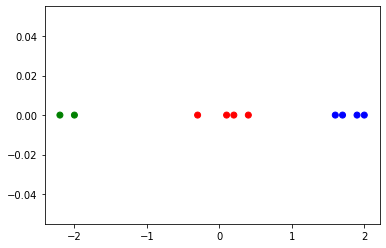

In [4]:
from matplotlib.colors import ListedColormap
c = ListedColormap(['red', 'green', 'blue'])
plt.scatter(d, np.zeros_like(d), c=clusters, cmap=c)
plt.show()

The result reflects the three "natural" clusters.

However, we do not always know how many clusters to expect. In this case we can simply generate a dendrogram to help us find the optimum number of clusters. For this, we can set the number of clusters to `None` and the distance threshold to 0, which will cause the algorithm to start with singleton clusters (effectively assigning each point to its own cluster) and then aggregating those into larger and larger ones:

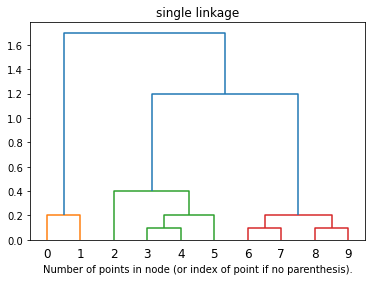

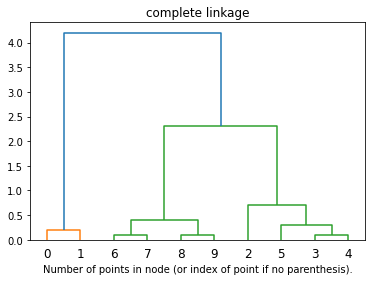

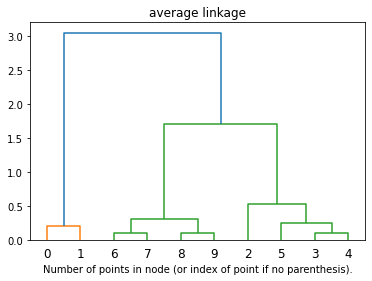

In [5]:
from tools.plots import plot_dendrogram

for linkage in ['single', 'complete', 'average']:
    # setting distance_threshold=0 ensures we compute the full tree.
    ac = AgglomerativeClustering(linkage=linkage, distance_threshold=0, n_clusters=None)
    ac = ac.fit(d)

    plot_dendrogram(ac, truncate_mode='level', p=4)
    plt.title(f"{linkage} linkage")
    plt.xlabel("Number of points in node (or index of point if no parenthesis).")
    plt.show()

From the `scipy` documentation for [hierarchy.dendrogram](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.dendrogram.html#scipy.cluster.hierarchy.dendrogram):
 > The dendrogram illustrates how each cluster is composed by drawing a U-shaped link between a non-singleton cluster and its children. The top of the U-link indicates a cluster merge. The two legs of the U-link indicate which clusters were merged. The length of the two legs of the U-link represents the distance between the child clusters. It is also the cophenetic distance between original observations in the two children clusters.
 
The colors in the dendrogram by default represent clusters that over `0.7*max_distance` away from their linked pair, where `max_distance` is the maximum distance between any two clusters in the diagram.

In our examples above, we can then see that the same three clusters tend to emerge.

We can access the data behind the dendrogram through the `children_` and `distances_` attributes:

In [6]:
ac = AgglomerativeClustering(linkage='single', distance_threshold=0, n_clusters=None)
ac = ac.fit(d)
ac.children_

array([[ 6,  7],
       [ 3,  4],
       [ 8,  9],
       [10, 12],
       [11,  5],
       [ 0,  1],
       [ 2, 14],
       [16, 13],
       [15, 17]])

`children_` lists the clusters in the order in which they are merged. For instance in the example above, the nodes 6 and 7 were merged first, forming a new cluster 10 (cluster indices start from 0). The second cluster merges 3 and 4 and creates cluster 11 and so on.

In [7]:
ac.distances_

array([0.1, 0.1, 0.1, 0.2, 0.2, 0.2, 0.4, 1.2, 1.7])

The `distances_` attribute shows the distance for each cluster join from `children_`. For instance, the distance between the first two clusters merged (6 and 7) is 0.1, while the distance between the last two clusters merged (15 and 17) is 1.7.

The dendrogram can help us find the natural clusters by finding biggest distance between two consecutive merges. If we look at the `distances_` attribute, we can see that the largest "jump" is from 0.4 to 1.2 ($1.2-0.4=0.8$ is the largest difference between two consecutive numbers). This means that the last two merges bring together rather distant clusters, so if we skip the last two merges, we end up with 3 clusters, as expected.